<a href="https://colab.research.google.com/github/highdee11/Intel-image-classification-pytorch/blob/main/Intel-image-classification-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:

import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

In [38]:
# Define directories
data_dir = '/content/drive/MyDrive/Colab data/intel_images'
train_dir = f'{data_dir}/seg_train/seg_train/'
test_dir = f'{data_dir}/seg_test/seg_test/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [39]:
# Define image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Load Data Set

In [40]:

from collections import defaultdict
import shutil
import random

def create_subset(input_dir, output_dir, num_images_per_class=200):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Dictionary to keep track of the images selected per class
    class_counts = defaultdict(int)

    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        # Create the class directory in the output folder
        output_class_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        # Get all image files in the class directory
        image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # Shuffle and select the required number of images
        random.shuffle(image_files)
        selected_images = image_files[:num_images_per_class]

        # Copy the selected images to the output directory
        for image_file in selected_images:
            src = os.path.join(class_dir, image_file)
            dst = os.path.join(output_class_dir, image_file)
            shutil.copyfile(src, dst)
            class_counts[class_name] += 1

    return class_counts


In [41]:
subset_train_dir = 'path_to_subset/intel_images/seg_train_subset'
subset_test_dir = 'path_to_subset/intel_images/seg_test_subset'


# Create subsets
train_class_counts = create_subset(train_dir, subset_train_dir, num_images_per_class=250)
test_class_counts = create_subset(test_dir, subset_test_dir, num_images_per_class=50)  # Adjust this number as needed


print(f'Training subset class counts: {train_class_counts}')
print(f'Test subset class counts: {test_class_counts}')

Training subset class counts: defaultdict(<class 'int'>, {'glacier': 250, 'buildings': 250, 'street': 250, 'mountain': 250, 'sea': 250, 'forest': 250})
Test subset class counts: defaultdict(<class 'int'>, {'street': 50, 'glacier': 50, 'mountain': 50, 'buildings': 50, 'sea': 50, 'forest': 50})


In [42]:
# Load the dataset with ImageFolder
# train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
# test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_dataset = datasets.ImageFolder(subset_train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(subset_test_dir, transform=data_transforms['test'])


### Preview Dataset Details

Categories of dataset: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']



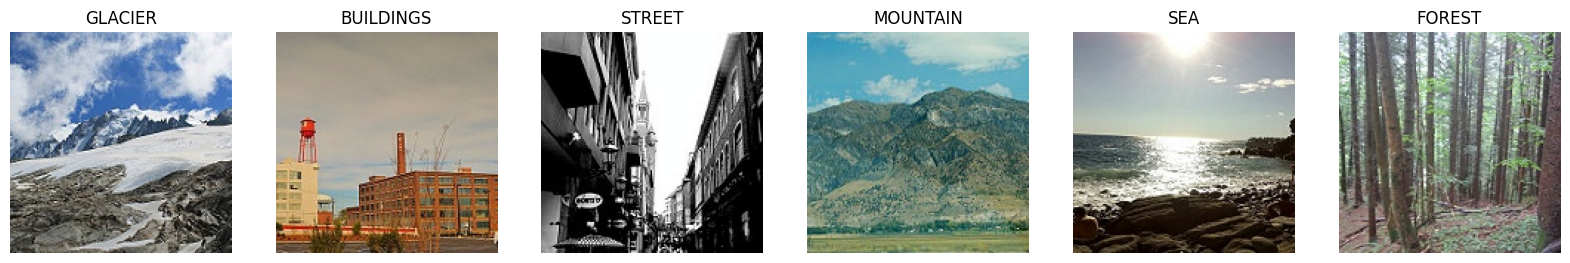

In [43]:
class_names = train_dataset.classes
print(f"Categories of dataset: {class_names}\n")

def view_images(image_paths):

  # Define the transformation (resize and normalize)
  transform = transforms.Compose([
      transforms.Resize((150, 150)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  # Load and transform images
  images = [transform(Image.open(img_path)) for img_path in image_paths]

  # Create a row of images
  fig, axes = plt.subplots(1, len(images), figsize=(20, 5))

  for i, img in enumerate(images):
      # Convert the tensor to a numpy array for plotting
      np_image = img.numpy().transpose((1, 2, 0))

      # Unnormalize the image for display
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      np_image = std * np_image + mean
      np_image = np.clip(np_image, 0, 1)

      axes[i].imshow(np_image)
      axes[i].axis('off')
      axes[i].set_title(image_paths[i].split("/")[-2].upper())

  plt.show()


# Retrieve first image of each category
folder_paths = [os.path.join(train_dir, img) for img in os.listdir(train_dir)[:6]]
image_paths = []

# Loop through each folder paths
for folder in folder_paths:
  first_image_path = os.listdir(folder)[0]
  image_paths.append(os.path.join(folder, first_image_path))

view_images(image_paths)

In [44]:
# Split the train dataset into training and validation sets

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [45]:
# Create data loaders
batch_size = 32

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 3. Model Selection and Architecture

In [46]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Load the pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Replace the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Number of classes

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 4. Model Training

In [47]:
import torch
import time
import copy

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

 # Move the model to the device
model = model.to(device)
# Training function with metrics recording
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies



# Plot the training and validation loss and accuracy
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Using device: cpu


In [48]:
# Train the model
num_epochs = 4
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=num_epochs)

Epoch 1/4
----------
train Loss: 0.9548 Acc: 0.6523
val Loss: 1.0561 Acc: 0.6514

Epoch 2/4
----------
train Loss: 0.6880 Acc: 0.7387
val Loss: 0.6743 Acc: 0.7447

Epoch 3/4
----------
train Loss: 0.6387 Acc: 0.7607
val Loss: 0.7863 Acc: 0.7430

Epoch 4/4
----------
train Loss: 0.6327 Acc: 0.7642
val Loss: 0.5944 Acc: 0.7958

Training complete in 46m 28s
Best val Acc: 0.7958


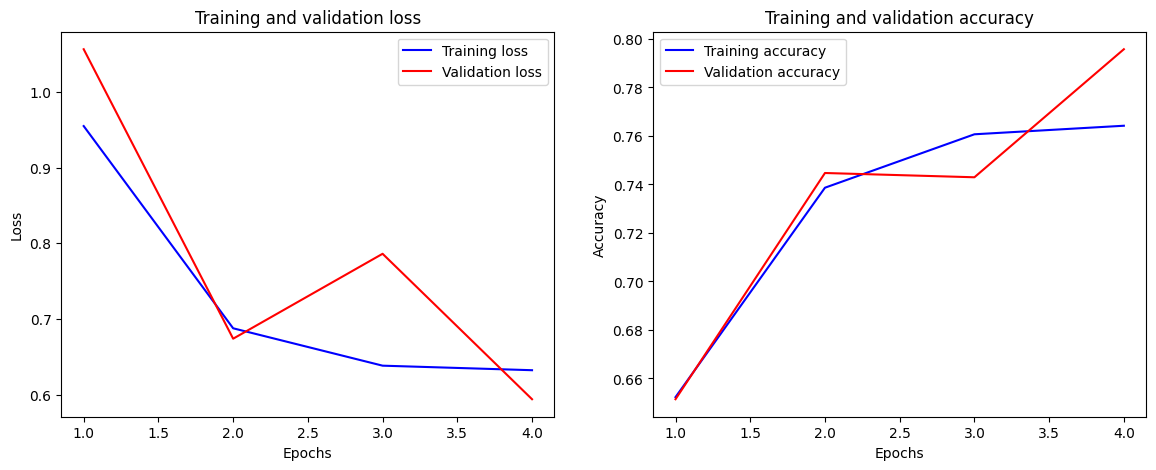

In [49]:
# Visualize the metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### 5. Hyperparameter Tuning:

In [51]:
# Increase Epochs
num_epochs = 6

# Set lr to 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model again
model2, train_losses2, val_losses2, train_accuracies2, val_accuracies2 = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=num_epochs)



Epoch 1/6
----------
train Loss: 0.6779 Acc: 0.7409
val Loss: 0.6195 Acc: 0.7817

Epoch 2/6
----------
train Loss: 0.5774 Acc: 0.7739
val Loss: 0.5737 Acc: 0.7870

Epoch 3/6
----------
train Loss: 0.5681 Acc: 0.7942
val Loss: 0.7527 Acc: 0.7412

Epoch 4/6
----------
train Loss: 0.5667 Acc: 0.7810
val Loss: 0.5491 Acc: 0.8099

Epoch 5/6
----------
train Loss: 0.5040 Acc: 0.8149
val Loss: 0.5733 Acc: 0.8011

Epoch 6/6
----------
train Loss: 0.5193 Acc: 0.8030
val Loss: 0.4166 Acc: 0.8592

Training complete in 70m 41s
Best val Acc: 0.8592


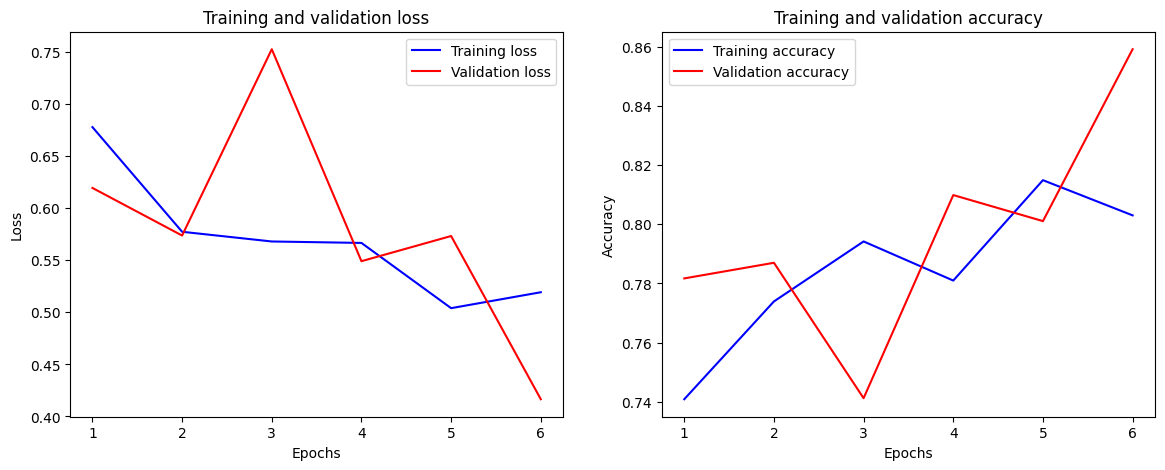

In [52]:
# Visualize the metrics
plot_metrics(train_losses2, val_losses2, train_accuracies2, val_accuracies2)

# 6. Evaluation

Classification Report:
              precision    recall  f1-score   support

   buildings       0.81      0.80      0.81        70
      forest       0.94      0.94      0.94       100
     glacier       0.76      0.82      0.79       111
    mountain       0.76      0.77      0.76        92
         sea       0.87      0.80      0.84       101
      street       0.86      0.85      0.86        94

    accuracy                           0.83       568
   macro avg       0.83      0.83      0.83       568
weighted avg       0.83      0.83      0.83       568

Confusion Matrix:


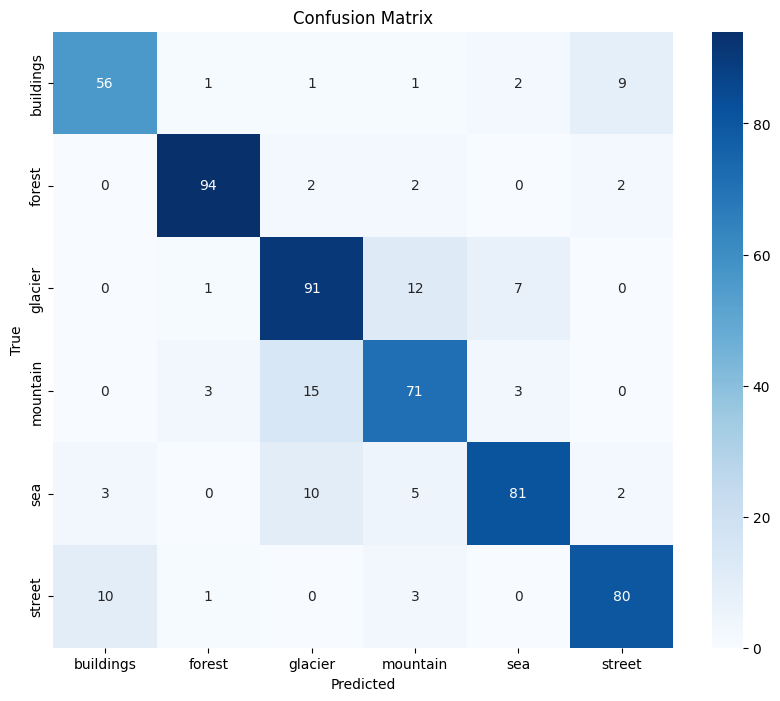

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns


# Evaluation function
def evaluate_model(model, dataloaders, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model
evaluate_model(model, dataloaders, device)


# 8. Final Model Testing

In [54]:
# Final testing function
def test_model(model, dataloaders, device):
    model.eval()
    test_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)

    test_acc = test_corrects.double() / dataset_sizes['test']
    print(f'Test Acc: {test_acc:.4f}')

# Test the model
test_model(model, dataloaders, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Acc: 0.8889


### Let's make some prediction and visualize them

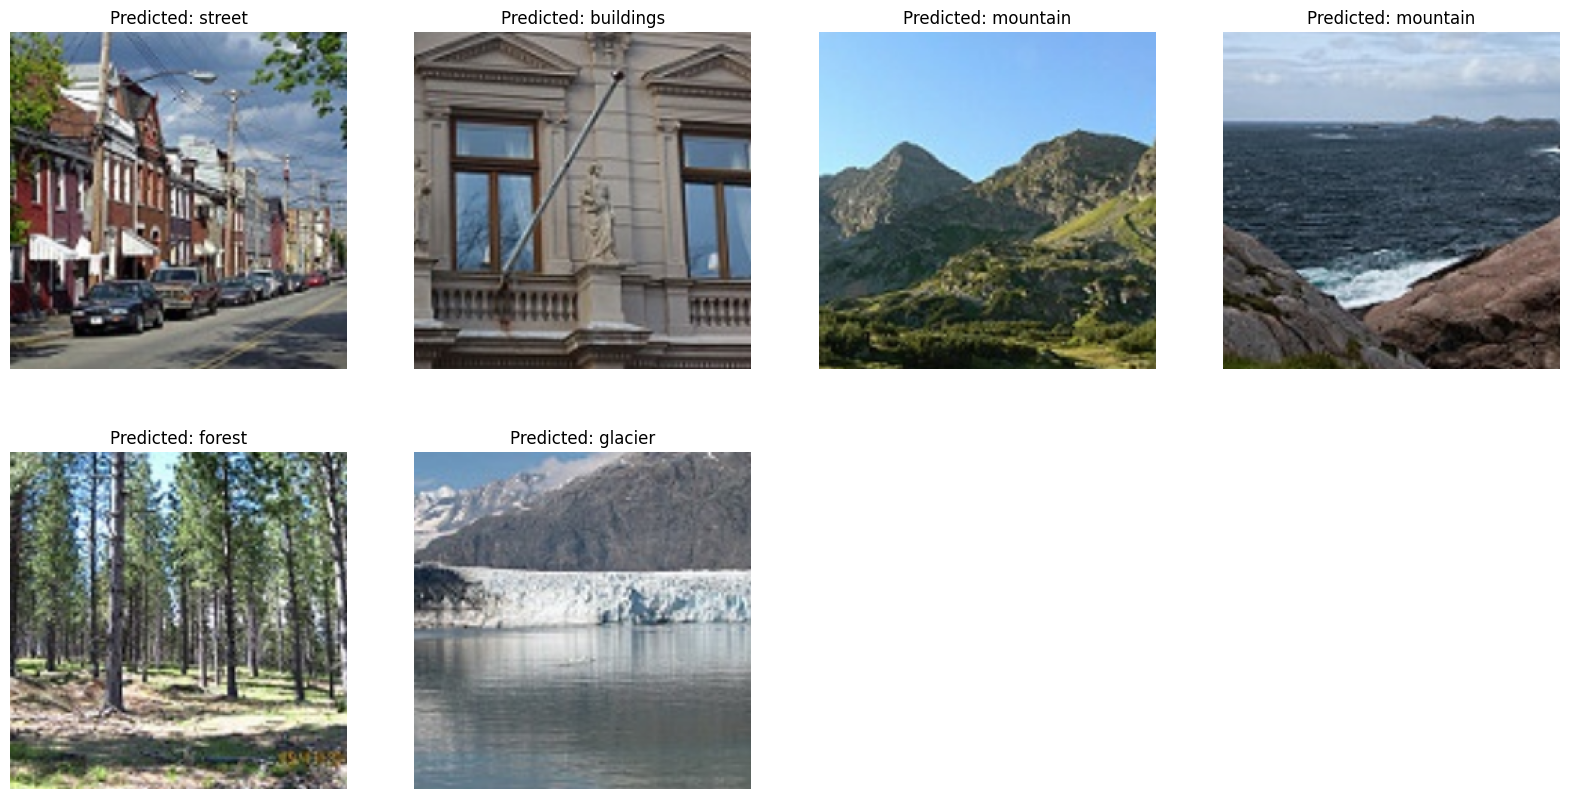

In [55]:
# Function to visualize the image and prediction
def visualize_predictions(model, dataloaders, device, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20, 10))

    # Calculate the number of images per class to visualize
    images_per_class = max(1, num_images // len(class_names))  # Ensure at least one image per class

    # Collect a balanced set of images
    class_images = {class_name: [] for class_name in class_names}

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                class_name = class_names[labels[i]]
                if len(class_images[class_name]) < images_per_class:
                    class_images[class_name].append((inputs[i], preds[i]))

    # Gather all collected images
    all_images = []
    for cls in class_names:
        all_images.extend(class_images[cls])

    num_images = len(all_images)

    # Randomize the collected images
    random.shuffle(all_images)

    for i in range(num_images):
        input_img, pred = all_images[i]
        images_so_far += 1
        ax = plt.subplot(2, 4, images_so_far)  # 2 rows and 4 columns
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[pred]}')
        img = input_img.cpu().data.numpy().transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        ax.imshow(img)

        if images_so_far == num_images:
            break


# Visualize predictions
visualize_predictions(model, dataloaders, device, num_images=6)